In [1]:
from sksurv.datasets import load_whas500
import numpy as np
import pandas as pd

In [2]:
def label_and_sort(score, columns):
    return round(pd.Series(score, index=columns).sort_values(ascending=False), 2)

## Load and Prep Data

In [3]:
data_raw = load_whas500()

In [4]:
# Split data into 
X_raw = data_raw[0]
y_raw = data_raw[1]

# Split our fstat - 
y_died = [int(y_tuple[0]) for y_tuple in y_raw]
y_lenfol = [y_tuple[1] for y_tuple in y_raw]

# Convert categorical variables to integers
X = X_raw.copy()
for col in X.columns:
    if X[col].dtype.name == 'category':
        X[col] = X[col].astype('int')
        

# Useful variables
n_obs = len(X)
features = X_raw.columns
features_cont = list(X_raw.columns[X_raw.dtypes == 'float64'])
features_bn = list(X_raw.columns[X_raw.dtypes == 'category'])

## General Analysis

### Basic Data Properties

In [5]:
features_cont

['age', 'bmi', 'diasbp', 'hr', 'los', 'sysbp']

In [6]:
features_bn

['afb', 'av3', 'chf', 'cvd', 'gender', 'miord', 'mitype', 'sho']

In [7]:
X.shape

(500, 14)

In [8]:
X.head()

afb   age  av3       bmi  chf  cvd  diasbp  gender    hr   los  miord  \
0    1  83.0    0  25.54051    0    1    78.0       0  89.0   5.0      1   
1    0  49.0    0  24.02398    0    1    60.0       0  84.0   5.0      0   
2    0  70.0    0  22.14290    0    0    88.0       1  83.0   5.0      0   
3    0  70.0    0  26.63187    1    1    76.0       0  65.0  10.0      0   
4    0  70.0    0  24.41255    0    1    85.0       0  63.0   6.0      0   

   mitype  sho  sysbp  
0       0    0  152.0  
1       1    0  120.0  
2       1    0  147.0  
3       1    0  123.0  
4       1    0  135.0

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

sns.pairplot(X_raw, hue = 'gender')
plt.show()

<Figure size 1564.22x1500 with 42 Axes>

In [10]:
# All categorical variables are binary - what positive rate do they each have?
for col in features_bn:
    positives = sum(X[col])
    rate = round(100 * positives / n_obs, 1)
    print(f'{col} - {positives} positives - {rate}%')

afb - 78 positives - 15.6%
av3 - 11 positives - 2.2%
chf - 155 positives - 31.0%
cvd - 375 positives - 75.0%
gender - 200 positives - 40.0%
miord - 171 positives - 34.2%
mitype - 153 positives - 30.6%
sho - 22 positives - 4.4%


av3 & sho have very low occurences in the data, we will likely want to exclude these from our patient clustering.

### Chi-squared test

A chi-squared test with each of our variables versus the target can give us an inital idea of feature importance.

In [11]:
#https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def feature_importance_chi2(X,y):
    bestfeatures = SelectKBest(score_func=chi2, k=14)
    fit = bestfeatures.fit(X,y)

    return label_and_sort(fit.scores_, X.columns)

fi_chi2 = feature_importance_chi2(X, y_died)
fi_chi2

age       354.57
hr        214.42
diasbp    104.93
chf        49.47
bmi        42.19
sysbp      20.06
los        11.31
sho        10.54
mitype     10.44
afb         9.48
gender      6.61
miord       6.47
av3         1.91
cvd         0.83
dtype: float64

In [12]:
fi_chi2[features_bn].sort_values(ascending = False)

chf       49.47
sho       10.54
mitype    10.44
afb        9.48
gender     6.61
miord      6.47
av3        1.91
cvd        0.83
dtype: float64

Age, Initial Heart Rate, and Initial Diastolic Blood Pressure are our initial top 3 candidates for the best features. Congestive Heart Complications is the most relevant binary feature.

### Correlation of variables

Highly correlated variables usually won't both be included in the clustering. They contain what can be thought of as duplicated information, the noise of which will be amplified if they're both included.

The `corr` method of `pd.DataFrame` uses Pearson's correlation coefficient by default

In [13]:
#Correlation of variables
corr = round(X.corr(),1)
corr

afb  age  av3  bmi  chf  cvd  diasbp  gender   hr  los  miord  mitype  \
afb     1.0  0.2  0.0 -0.1  0.2  0.0     0.0     0.0  0.1  0.2   -0.0    -0.0   
age     0.2  1.0  0.1 -0.4  0.3  0.2    -0.2     0.3  0.1  0.1    0.2    -0.2   
av3     0.0  0.1  1.0 -0.1  0.1  0.0    -0.0    -0.0 -0.1  0.0   -0.1     0.1   
bmi    -0.1 -0.4 -0.1  1.0 -0.1  0.1     0.2    -0.1 -0.1 -0.1   -0.1     0.1   
chf     0.2  0.3  0.1 -0.1  1.0  0.1    -0.1     0.2  0.2  0.2    0.1    -0.1   
cvd     0.0  0.2  0.0  0.1  0.1  1.0     0.0     0.1 -0.0  0.0    0.2    -0.2   
diasbp  0.0 -0.2 -0.0  0.2 -0.1  0.0     1.0    -0.1  0.1  0.0   -0.1     0.1   
gender  0.0  0.3 -0.0 -0.1  0.2  0.1    -0.1     1.0  0.1  0.1    0.0    -0.2   
hr      0.1  0.1 -0.1 -0.1  0.2 -0.0     0.1     0.1  1.0  0.1    0.1    -0.2   
los     0.2  0.1  0.0 -0.1  0.2  0.0     0.0     0.1  0.1  1.0   -0.0     0.0   
miord  -0.0  0.2 -0.1 -0.1  0.1  0.2    -0.1     0.0  0.1 -0.0    1.0    -0.3   
mitype -0.0 -0.2  0.1  0.1 -0.1 -0.2     0.1    -0.2 -0.2  0.0   -0.3     1.0   
sho     0.1  0.1  0.1 -0.1  0.2  0.0    -0.1     0.0 -0.0  0.2   -0.1     0.1   
sysbp  -0.1 -0.0 -0.1  0.1 -0.0  0.1     0.6     0.1 -0.0  0.0    0.0    -0.1   

        sho  sysbp  
afb     0.1   -0.1  
age     0.1   -0.0  
av3     0.1   -0.1  
bmi    -0.1    0.1  
chf     0.2   -0.0  
cvd     0.0    0.1  
diasbp -0.1    0.6  
gender  0.0    0.1  
hr     -0.0   -0.0  
los     0.2    0.0  
miord  -0.1    0.0  
mitype  0.1   -0.1  
sho     1.0   -0.2  
sysbp  -0.2    1.0

The only pairs of correlated variables are sysbp & diasbp (systolic & diastolic blood pressure): 0.6, age & bmi: -0.4, and age & chf (Congestive heart complications): 0.3. These pairs seem to make sense.

0.6 for sysbp & diasbp is potentially quite high, 0.7 is a good rule of thumb for a cutoff. We could include both of them in the clustering, only one, or combine them both into a new feature e.g mean blood pressure.

**TODO:** Assess if Pearson's CC is appropriate for binary variables, which account for most of our features.

### Heiarchical clustering to see similar features

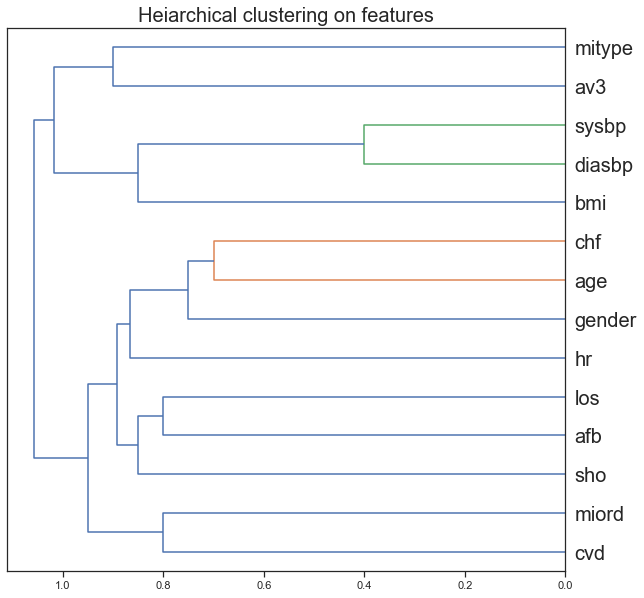

In [14]:
# Heiarchical clustering on features to see similar ones
from scipy.cluster import hierarchy as hc
import scipy

corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')

fig = plt.figure(figsize=(10,10))
#TODO map column names to human readable
dendrogram = hc.dendrogram(z, labels=X.columns, orientation='left', leaf_font_size=20)
plt.title('Heiarchical clustering on features', fontsize=20)
plt.show()

A similar story to the Pearsons correlation analysis, although this gives us a better idea of how groups of variables are related to eachother. Interestingly, `age` & `bmi` are more corelated than `age` & `chf` (Congestive Heart Complications), but the heirarichal clustering has found the latter pair to be more closely related.

## K-means Clustering

K-means clustering is an unsurpervised algorithm which will split our patients into distinct non-overlapping groups. Given a number of K clusters and a random intial state for those K clusters, it iterates until a set of stable clusters emerge.

Our features need to be normalised, outliers capped or removed, and would ideally be normally distributed. This can be achieved easily for our continuous varibles, however we will struggle to get our binary variables to be normally distributed, so will simply normalise those.

#### Normally distributed features

Normally distributed data should have a straight line on a quantile-quantile plot

age


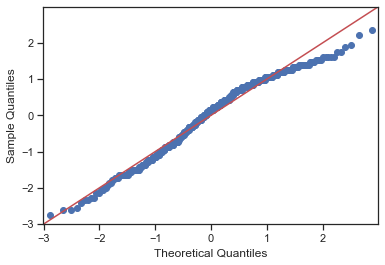

bmi


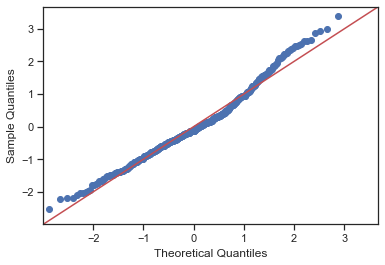

diasbp


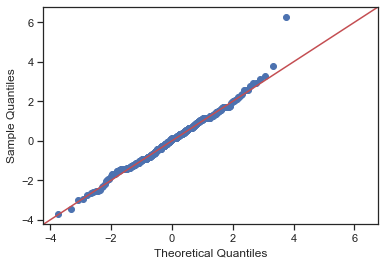

hr


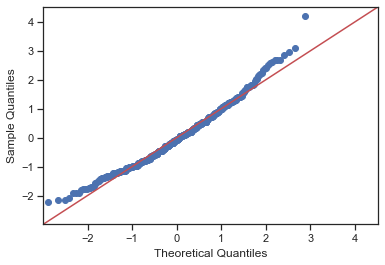

los


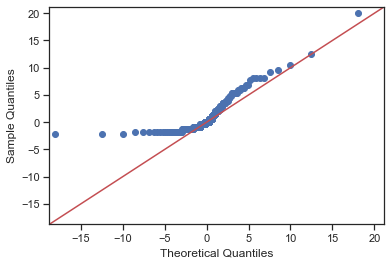

sysbp


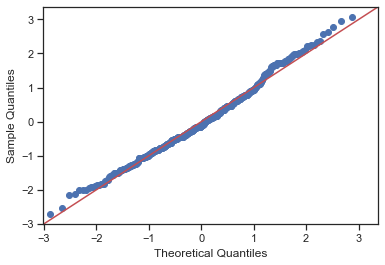

In [15]:
# https://towardsdatascience.com/6-ways-to-test-for-a-normal-distribution-which-one-to-use-9dcf47d8fa93
import statsmodels.api as sm
import scipy.stats as stats
for col in features_cont:
    print(col)
    sm.qqplot(X[col], stats.t, fit=True, line="45")
    plt.show()

`los` (length of stay) seems to be the only continuous variable that is not normally distributed. The downward bend of this plot is charactaristic of an exponential curve, which can be made normal by simply logging.

In [16]:
X['los'].describe()

count    500.000000
mean       6.116000
std        4.714127
min        0.000000
25%        3.000000
50%        5.000000
75%        7.000000
max       47.000000
Name: los, dtype: float64

Zeros will be an issue if we try to take the log.

In [17]:
sum(X['los'] == 0)

3

3 patients with 0 days in hospital is not enough to worry about, these can be rounded up to 1 with minimal effect on the clustering.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


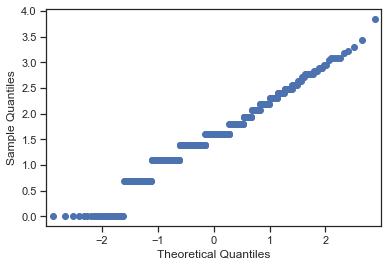

In [18]:
X['los'][X['los'] == 0] = 1
X['los_log'] = np.log(X['los'])
sm.qqplot(X['los_log'])
plt.show()

This is the linear plot we want, the `los_log` can be used in our clustering instead of `los`.

### Outlier Capping

As the name implies, k-**means** clustering, involves many iterations of taking the mean of the cluster centroids after each step. The mean can be easily affected by outliers so we will have to cap them before passing our data to the clustering algorithm.

In [19]:
def treat_outliers(df, columns=None, factor=2, method='IQR', treatment='cap', loud = True):
    """
    Caps or removes the rows from df whose values do not lies in the specified standard deviation
    """
    if not columns:
        columns = df.columns
    
    for column in columns:
        if method == 'STD':
            permissable_std = factor * df[column].std()
            col_mean = df[column].mean()
            floor, ceil = col_mean - permissable_std, col_mean + permissable_std
        elif method == 'IQR':
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            floor, ceil = Q1 - factor * IQR, Q3 + factor * IQR
            
        
        if loud:
            high = sum(df[column] > ceil)
            low = sum(df[column] < floor)
            
            print(f'{column} - {high} values above cieling, {low} values below floor')

        
        if treatment == 'remove':
            df = df[(df[column] >= floor) & (df[column] <= ceil)]
        elif treatment == 'cap':
            df[column] = df[column].clip(floor, ceil)
            

            
    return df

In [20]:
X_proc = treat_outliers(X, features_cont)

age - 0 values above cieling, 0 values below floor
bmi - 4 values above cieling, 0 values below floor
diasbp - 2 values above cieling, 1 values below floor
hr - 1 values above cieling, 0 values below floor
los - 26 values above cieling, 0 values below floor
sysbp - 0 values above cieling, 0 values below floor


### Clustering

The data is now ready for clustering, it simply needs normalising, then passing into the `KMeans` model. The top features from the Chi-squared analysis will be used to cluster only on the most relevant featues.

In [21]:
# Using top 7 features
n = 10
top_features = list(fi_chi2.index[0:n])
top_features

['age', 'hr', 'diasbp', 'chf', 'bmi', 'sysbp', 'los', 'sho', 'mitype', 'afb']

In [22]:
# Use los_log
top_features[6] = 'los_log'

### After some experimenting, sho turns out to be a useful variable, despite only occuring in 4% of the data.
# # Remove sho
# top_features.remove('sho')

X_proc_top = X_proc[top_features]

In [23]:
X_proc_top.head()

age    hr  diasbp  chf       bmi  sysbp   los_log  sho  mitype  afb
0  83.0  89.0    78.0    0  25.54051  152.0  1.609438    0       0    1
1  49.0  84.0    60.0    0  24.02398  120.0  1.609438    0       1    0
2  70.0  83.0    88.0    0  22.14290  147.0  1.609438    0       1    0
3  70.0  65.0    76.0    1  26.63187  123.0  2.302585    0       1    0
4  70.0  63.0    85.0    0  24.41255  135.0  1.791759    0       1    0

In [24]:
# From datacamp course on k-means clustering.
# Normalise df columns using sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Initialize and fit a scaler
scaler = StandardScaler()
scaler.fit(X_proc_top)

# Scale and center the data
X_normalized = scaler.transform(X_proc_top)
X_normalized = pd.DataFrame(X_normalized, index=X_proc_top.index, columns=X_proc_top.columns)

One downside of K-means is that it can sometimes be difficult to know the right number to chose for K - the number of clusters. Ideally you would think about the use case for these clusters, what actions will you be taking off the back of this clustering?

However, the 'Elbow Method' can be of some help - We expect the sum of squared errors to drop as more clusters are added, we are after the sweet spot, when adding more clusters seems to stop being quite as effective.

In [25]:
 # Fit KMeans and calculate SSE for each k between 1 and 10
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(X_normalized)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_ 

In [26]:
fig = plt.figure(figsize=(8,6))
plt.title('The Elbow Method', fontsize = 15)
plt.xlabel('k', fontsize = 15)
plt.ylabel('SSE', fontsize = 15)

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

No obvious elbow is present. `k=5` seems to have quite a sharp decline from `k=4`, so this can be our intial choice.

In [27]:
# KMeans for k = 5
kmeans = KMeans(n_clusters=5, random_state=1) 
kmeans.fit(X_normalized)
cluster_labels = kmeans.labels_

# Create a DataFrame by adding a new cluster label column
X_lab = X_proc.assign(Cluster=cluster_labels)
# X_normalized_lab = X_normalized.assign(Cluster=cluster_labels)

# Add y_died and group the data by cluster
X_lab['y_died'] = y_died
grouped = X_lab.groupby(['Cluster'])

In [28]:
# Dictionary to be argument for .agg method
cols_dict = dict.fromkeys(X.columns, "mean")
cols_dict['y_died'] = ['count', 'mean']

# Calculate count and mean values per cluster
cluster_means = grouped.agg(cols_dict).round(1)
cluster_means

afb   age  av3   bmi  chf  cvd diasbp gender    hr  los miord mitype  \
        mean  mean mean  mean mean mean   mean   mean  mean mean  mean   mean   
Cluster                                                                         
0        0.0  62.2  0.0  29.1  0.0  0.8   80.3    0.4  80.3  4.8   0.4    0.0   
1        0.0  81.0  0.0  23.5  0.6  0.8   71.2    0.5  98.1  5.7   0.5    0.1   
2        1.0  75.2  0.0  25.2  0.4  0.7   78.7    0.5  94.7  7.8   0.3    0.3   
3        0.4  76.0  0.1  25.1  0.6  0.8   72.8    0.4  81.7  8.3   0.2    0.5   
4        0.0  61.9  0.0  28.2  0.2  0.6   84.6    0.2  78.5  5.6   0.1    1.0   

         sho  sysbp los_log y_died       
        mean   mean    mean  count mean  
Cluster                                  
0          0  150.4     1.4    153  0.2  
1          0  145.2     1.6    141  0.7  
2          0  138.7     1.9     69  0.6  
3          1  121.4     1.9     22  0.8  
4          0  144.6     1.6    115  0.2

In [29]:
# Means and counts for 10 features actually used for clustering
cluster_means[top_features]

age    hr diasbp  chf   bmi  sysbp los_log  sho mitype  afb
         mean  mean   mean mean  mean   mean    mean mean   mean mean
Cluster                                                              
0        62.2  80.3   80.3  0.0  29.1  150.4     1.4    0    0.0  0.0
1        81.0  98.1   71.2  0.6  23.5  145.2     1.6    0    0.1  0.0
2        75.2  94.7   78.7  0.4  25.2  138.7     1.9    0    0.3  1.0
3        76.0  81.7   72.8  0.6  25.1  121.4     1.9    1    0.5  0.4
4        61.9  78.5   84.6  0.2  28.2  144.6     1.6    0    1.0  0.0

In [30]:
cluster_means[top_features].to_csv('cluster_means.csv')

These are our final cluster outputs.

## Survival Analysis

In [31]:
# https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(y_raw["fstat"], y_raw["lenfol"])


fig = plt.figure(figsize=(8,6))
plt.title('Kaplan Meier Curve', fontsize = 15)
plt.ylabel("Probability of survival", fontsize = 15)
plt.xlabel("Time in days since last follow-up", fontsize = 15)

sns.lineplot(x=time,y=survival_prob, drawstyle='steps-pre')
plt.show()

The sharp drop at the end of this graph represents patients who were still alive by the time the study finished. These are known as 'censored' data points, since we do not know when or if they have died, but we still wish to use what information we do have to inform our model.

In [32]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

# Remove los_log, it is no longer needed.
X_proc = X_proc.drop('los_log', axis = 1)

estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_proc, y_raw)
label_and_sort(abs(estimator.coef_), features)

sho       1.25
chf       0.72
av3       0.32
gender    0.30
mitype    0.22
miord     0.08
cvd       0.05
bmi       0.05
age       0.05
afb       0.04
diasbp    0.01
hr        0.01
los       0.01
sysbp     0.00
dtype: float64

`sho` (Cardiogenic Shock) has the largest coefficient. We can see from the grouped cluster means table that this feature is 100% corelated with cluster 2 - a cluster where 80% of patients died. It performed poorly in the chi-squared test because only 4.4% of patients have it, cluster 2 is the smallest cluster. Cardiogenic Shock is clearly a rare, but incredibly serious event.

In [33]:
import numpy as np

def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(X_proc.values, y_raw)
fi_cox = label_and_sort(scores, features)
fi_cox

age       0.73
bmi       0.65
chf       0.64
hr        0.61
diasbp    0.61
sysbp     0.56
mitype    0.56
gender    0.54
miord     0.54
afb       0.54
sho       0.54
cvd       0.52
los       0.51
av3       0.51
dtype: float64

In [34]:
# Chi-squared results
# age        354.57
# hr         214.42
# diasbp     104.93
# chf         49.47
# bmi         42.19
# sysbp       20.06
# los         10.98
# sho         10.54
# mitype      10.44
# afb          9.48
# gender       6.61
# miord        6.47
# av3          1.91
# cvd          0.83
# los_log      0.53

When features are examined individually, it gives a very similar story to the chi-squared test.

## Principal component analysis

In [35]:
#https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e
#https://medium.com/analytics-vidhya/implementation-of-principal-component-analysis-pca-in-k-means-clustering-b4bc0aa79cb6
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_proc)
X_transform = scaler.transform(X_proc)
pca = PCA(n_components=5) # estimate the top 5 principal components
X_pca = pca.fit_transform(X_transform) # project the original data into the PCA space

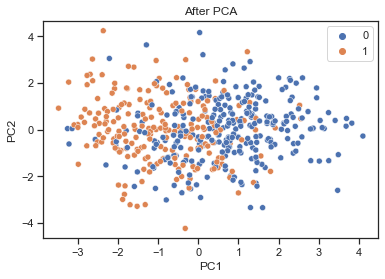

In [36]:
# Survival plotted against top 2 features from Cox Analysis
fi_0 = fi_cox.index[0] # age
fi_1 = fi_cox.index[1] # bmi

sns.scatterplot(x=X[fi_0], y=X[fi_1], hue = y_died)

plt.title('Before PCA')
plt.show()

# Survival plotted against top 2 principal components
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue = y_died)

plt.title('After PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

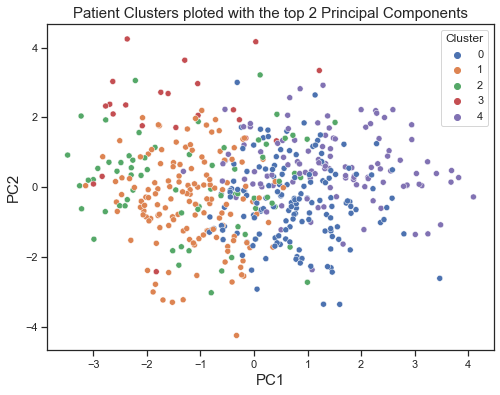

In [37]:
# Original patient clusters against top 2 principal components
fig = plt.figure(figsize=(8,6))
plt.title('Patient Clusters ploted with the top 2 Principal Components', fontsize = 15)
plt.xlabel('PC1',fontsize = 15)
plt.ylabel('PC2',fontsize = 15)

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue = X_lab.Cluster, palette = 'deep')
plt.show()

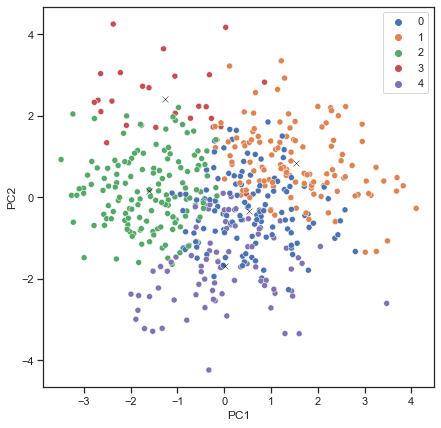

In [38]:
# Clustering using only the top two principal components
pca_kmeans = KMeans(n_clusters = 5, random_state = 1)
label = pca_kmeans.fit_predict(X_pca)
centers = np.array(pca_kmeans.cluster_centers_)

plt.figure(figsize=(7,7))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue = label, palette = 'deep')    
#This is done to find the centroid for each clusters.
sns.scatterplot(x=centers[:,0], y=centers[:,1], marker="x", color='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [39]:
# Write components to dictionary
components_raw = abs(pca.components_)
components = {}
for i in range(len(components_raw)):
    labelled_eigenvec = label_and_sort(components_raw[i], features)
    normalised_eigenvec = round(labelled_eigenvec / sum(labelled_eigenvec), 2)
    
    pc_name = 'pc' + str(i)
    components[pc_name] = normalised_eigenvec
    
components

{'pc0': age       0.14
 chf       0.11
 bmi       0.10
 gender    0.09
 diasbp    0.08
 mitype    0.08
 miord     0.07
 afb       0.06
 hr        0.06
 los       0.06
 cvd       0.05
 sysbp     0.04
 sho       0.04
 av3       0.01
 dtype: float64, 'pc1': sysbp     0.19
 diasbp    0.15
 cvd       0.10
 mitype    0.10
 sho       0.09
 hr        0.08
 miord     0.07
 av3       0.06
 gender    0.06
 bmi       0.04
 afb       0.03
 chf       0.02
 age       0.02
 los       0.00
 dtype: float64, 'pc2': los       0.14
 afb       0.12
 diasbp    0.12
 mitype    0.12
 miord     0.12
 sho       0.11
 chf       0.07
 sysbp     0.06
 av3       0.05
 hr        0.03
 cvd       0.02
 gender    0.02
 bmi       0.02
 age       0.01
 dtype: float64, 'pc3': hr        0.23
 av3       0.21
 cvd       0.20
 sho       0.09
 sysbp     0.06
 afb       0.06
 miord     0.06
 bmi       0.03
 age       0.02
 los       0.02
 mitype    0.01
 diasbp    0.01
 gender    0.01
 chf       0.00
 dtype: float64, 'pc4': bmi 

In [41]:
#TODO Chi SQ & Cox with PCs components